In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.datasets import make_classification



In [2]:
df = pd.read_csv('./accepted.csv.gz', compression='gzip')
len(df)

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_2141/1192883518.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./accepted.csv.gz', compression='gzip')


2260701

In [3]:
df['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid                                             0.476298
Current                                                0.388521
Charged Off                                            0.118796
Late (31-120 days)                                     0.009496
In Grace Period                                        0.003732
Late (16-30 days)                                      0.001924
Does not meet the credit policy. Status:Fully Paid     0.000879
Does not meet the credit policy. Status:Charged Off    0.000337
Default                                                0.000018
Name: proportion, dtype: float64

# Data Cleaning

In [4]:
# # Updating the loan statuses -> categorizing them into the similar types 

df = df.loc[df['loan_status'] != 'Current'].reset_index(drop=True)
df = df.loc[~df['loan_status'].isna()]
def update_loan_status(loan_status):
    if 'Fully Paid' in loan_status: 
        return 1
    else: 
        return 0 

df['loan_status'] = df['loan_status'].apply(lambda x : update_loan_status(x))
df['loan_status'].value_counts(normalize=True)

loan_status
1    0.780365
0    0.219635
Name: proportion, dtype: float64

In [5]:
# Removing columns with >60% of NaN values 

na_df = df.isna().sum().reset_index()
na_df.rename(columns = {'index': 'variable', 0:'na_count'},inplace=True)
na_df['count'] = len(df)
na_df['%_missing'] = (na_df['na_count'] / na_df['count']) * 100 
na_df = na_df.loc[na_df['%_missing'] < 30] #70% as the threshold 
accepted_variables = list(na_df['variable'])

df = df[accepted_variables]
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
4,68426831,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


In [6]:
cols = list(df.columns)
isolated_cols = [i for i in cols if 'inv' not in i]
df = df[isolated_cols]

object_columns = df.select_dtypes('object')
unique_counts = object_columns.apply(pd.Series.nunique, axis=0)
cols_to_drop = unique_counts[unique_counts > 50].index.tolist()
df.drop(columns = cols_to_drop, inplace=True)

In [7]:
df['emp_length'].fillna(0,inplace=True)
def process_emp_length(emp_length):
    if emp_length == '< 1 year':
        return 0
    elif emp_length == '10+ years':
        return 11
    elif emp_length == 0: 
        return 0
    else:
        return int(emp_length.split()[0])

df['emp_length'] = df['emp_length'].apply(process_emp_length)
df['emp_length'].value_counts()

emp_length
11    453281
0     193205
2     125246
3     110684
1      91130
5      86452
4      82975
6      64377
8      62043
7      60927
9      52031
Name: count, dtype: int64

In [8]:
# Treating NaN values 

# Remove rows with loan amount / funded amount as na -> since we are unable to determine the status of the loan 
df = df.loc[~df['loan_amnt'].isna()].reset_index(drop=True)

# Employment Length, Annual Income -> median 
employment_info = ['annual_inc', 'emp_length']

for col in employment_info: 
    if col == 'emp_length': 
        median_value = df['emp_length'].value_counts().median()
        median_index = df['emp_length'].value_counts().index[df['emp_length'].value_counts() == median_value][0]
        df[col] = df[col].fillna(median_index)
    else:
        df[col] = df[col].fillna(df[col].median())

# dti, delinq_2yrs, open_acc, open_acc, revol_bal, revol_util, total_acc,tot_cur_bal  -> mean
financial_info = ['dti', 'delinq_2yrs', 'open_acc', 'revol_bal', 'revol_util', 'total_acc','tot_cur_bal', 
                 'acc_open_past_24mths', 'avg_cur_bal', 'delinq_amnt', 'mort_acc', 'tax_liens']

for col in financial_info: 
    df[col] = df[col].fillna(df[col].mean())
    
# last date of payment, title -> '-'
# for col in misc_cols: 
#     df[col] = df[col].fillna('-')

# acc_now_delinq, tot_coll_amt, 'pub_rec_bankruptcies', 'pub_rec' -> 0
# 'pub_rec_bankruptcies', 'pub_rec' -> suggests cleanliness of the record 
account_info = ['acc_now_delinq', 'tot_coll_amt', 'pub_rec_bankruptcies', 'pub_rec']
for col in account_info: 
    df[col] = df[col].fillna(0)

df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,36 months,13.99,123.03,C,C4,11,MORTGAGE,55000.0,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,36 months,11.99,820.28,C,C1,11,MORTGAGE,65000.0,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,60 months,10.78,432.66,B,B4,11,MORTGAGE,63000.0,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,10400.0,10400.0,60 months,22.45,289.91,F,F1,3,MORTGAGE,104433.0,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
4,11950.0,11950.0,36 months,13.44,405.18,C,C3,4,RENT,34000.0,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


In [9]:
na_df = pd.DataFrame(df.isna().sum().reset_index())
null_cols = na_df.loc[na_df[0] > 0]['index'].values

In [10]:
cols = df.select_dtypes('object').columns 
df[cols].loc[0,:]

term                             36 months
grade                                    C
sub_grade                               C4
home_ownership                    MORTGAGE
verification_status           Not Verified
pymnt_plan                               n
purpose                 debt_consolidation
initial_list_status                      w
application_type                Individual
hardship_flag                            N
disbursement_method                   Cash
debt_settlement_flag                     N
Name: 0, dtype: object

In [11]:
df['home_ownership'].value_counts

<bound method IndexOpsMixin.value_counts of 0          MORTGAGE
1          MORTGAGE
2          MORTGAGE
3          MORTGAGE
4              RENT
             ...   
1382346         OWN
1382347    MORTGAGE
1382348    MORTGAGE
1382349        RENT
1382350        RENT
Name: home_ownership, Length: 1382351, dtype: object>

In [12]:
null_float_cols = [i for i in null_cols if i not in cols]
for col in null_float_cols: 
    df[col] = df[col].fillna(df[col].mean())
    

In [13]:
na_df = pd.DataFrame(df.isna().sum().reset_index())
na_df.loc[na_df[0] > 0]['index'].values

array([], dtype=object)

In [14]:
column_name = 'grade'
unique_values = df[column_name].sort_values().unique()
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
df[column_name] = df[column_name].map(mapping_dict)


In [15]:
column_name = 'sub_grade'
unique_values = df[column_name].sort_values().unique()
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
df[column_name] = df[column_name].map(mapping_dict)


Get dummies


In [16]:
# one hot encoding 
cols = df.select_dtypes('object').columns 

In [17]:
for column in cols:
    unique_values = df[column].unique()
    print(f"Unique values in column {column}: {len(unique_values)}")
    mapping = {value: idx for idx, value in enumerate(unique_values)}
    df[column] = df[column].map(mapping)
    print(f"Binary mapping for column {column}: {mapping}")

Unique values in column term: 2
Binary mapping for column term: {' 36 months': 0, ' 60 months': 1}
Unique values in column home_ownership: 6
Binary mapping for column home_ownership: {'MORTGAGE': 0, 'RENT': 1, 'OWN': 2, 'ANY': 3, 'NONE': 4, 'OTHER': 5}
Unique values in column verification_status: 3
Binary mapping for column verification_status: {'Not Verified': 0, 'Source Verified': 1, 'Verified': 2}
Unique values in column pymnt_plan: 2
Binary mapping for column pymnt_plan: {'n': 0, 'y': 1}
Unique values in column purpose: 14
Binary mapping for column purpose: {'debt_consolidation': 0, 'small_business': 1, 'home_improvement': 2, 'major_purchase': 3, 'credit_card': 4, 'other': 5, 'house': 6, 'vacation': 7, 'car': 8, 'medical': 9, 'moving': 10, 'renewable_energy': 11, 'wedding': 12, 'educational': 13}
Unique values in column initial_list_status: 2
Binary mapping for column initial_list_status: {'w': 0, 'f': 1}
Unique values in column application_type: 2
Binary mapping for column applica

In [18]:
df['loan_status'].value_counts(normalize=True)

loan_status
1    0.780365
0    0.219635
Name: proportion, dtype: float64

In [19]:
cols = df.select_dtypes('object').columns 
cols

Index([], dtype='object')

In [20]:
df.isna().sum().sum()

0

In [21]:
len(df)

1382351

# Check for Imbalances in Data + Splitting Train Test Data

In [22]:
target_column = 'loan_status'
x = df.drop(target_column, axis = 1)
y = df[target_column]
y = y.astype(int)


In [23]:
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imblearn 0.0
Uninstalling imblearn-0.0:
  Successfully uninstalled imblearn-0.0
  Obtaining dependency information for scikit-learn==1.2.2 from https://files.pythonhosted.org/packages/27/4a/1afe473760b07663710a75437b795ef37362aebb8bf513ff3bbf78fbd0c6/scikit_learn-1.2.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-macosx_10_9_x86_64.whl (9.0 MB)
  Obtaining dependency information for imblearn from https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl.metadata
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


##  Downsampling of majority class

In [24]:
from sklearn.utils import resample

In [25]:
from sklearn.utils import resample
fully_paid = df.loc[df[target_column] == 1]
default = df.loc[df[target_column] == 0]
fully_paid_downsample = resample(fully_paid,
             replace=True,
             n_samples=len(default),
             random_state=42)
data_downsampled = pd.concat([fully_paid_downsample, default])
print(data_downsampled[target_column].value_counts())

loan_status
1    303612
0    303612
Name: count, dtype: int64


In [26]:
fully_paid_downsample = resample(fully_paid,
             replace=True,
             n_samples=len(default),
             random_state=42)

print(fully_paid_downsample.shape)

(303612, 80)


In [27]:
data_downsampled = pd.concat([fully_paid_downsample, default])
print(data_downsampled[target_column].value_counts())

loan_status
1    303612
0    303612
Name: count, dtype: int64


# Normalization of dataset + Dataset Split + Downsampling

In [28]:
from sklearn.preprocessing import StandardScaler 


x = data_downsampled.drop(target_column, axis=1)
y = data_downsampled[target_column]
y = y.astype(int)

numeric_columns = x.select_dtypes(include=['float64']).columns

scaler = StandardScaler()
scaler.fit(x[numeric_columns]) 
scaled_data = scaler.transform(x[numeric_columns]) 
scaled_df = pd.DataFrame(scaled_data, columns=numeric_columns) 


scaled_df.reset_index(drop=True, inplace=True)

non_numeric_columns = x.select_dtypes(exclude=['float64']).columns
non_numeric_df = x[non_numeric_columns]
non_numeric_df.reset_index(drop=True, inplace=True)

x_combined = pd.concat([scaled_df, non_numeric_df], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_combined, y, test_size=0.3, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((425056, 79), (182168, 79), (425056,), (182168,))

# Methods

In [29]:
def elbow_joint(cols, x_train):
    k1 = []
    inertia_s1 = []

    for i in tqdm(range(1,11)):
        print(i)
        k1.append(i)
        kmeans = KMeans(n_clusters=i, random_state = 42).fit(x_train[cols])
        inertia_s1.append(kmeans.inertia_)

    plt.figure(figsize=(15,5))
    plt.plot(k1,inertia_s1,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Inertia (SSE) vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Inertia score (SSE)')
    
def clustering(n_clusters, cluster_identity, cols, x_train, x_test): 
    kmeans = KMeans(n_clusters=n_clusters, random_state = 42).fit(x_train[cols])
    x_train[f'cluster_ids_{cluster_identity}'] = kmeans.labels_
    df_profile_overall = x_train.describe().T

    df_profile_overall['Overall Dataset'] = df_profile_overall[['mean']]
    df_profile_overall = df_profile_overall[['Overall Dataset']]

    df_cluster_summary = x_train.groupby(f'cluster_ids_{cluster_identity}').describe().T.reset_index()
    df_cluster_summary = df_cluster_summary.rename(columns={'level_0':'column','level_1':'metric'})

    df_cluster_summary = df_cluster_summary[df_cluster_summary['metric'] == "mean"]
    df_cluster_summary = df_cluster_summary.loc[df_cluster_summary['column'].isin(cols)]
    x_test[f'cluster_ids_{cluster_identity}'] = kmeans.predict(x_test[cols])
    return df_cluster_summary, x_train, x_test

def create_customer_profile(row):
    profile = []
    for feature in important_features:
        profile.append(f"{feature}: {row[feature]}")
    return ', '.join(profile)

def feature_importance(grid_search, x_train):
    est = grid_search.best_estimator_
    imp_df = pd.DataFrame({
        "Varname": x_train.columns,
        "Imp": est.feature_importances_
    })
    imp_df = imp_df.sort_values(by = 'Imp', ascending = True)

    plt.figure(figsize=(10, 6)) 
    imp_df.set_index('Varname').plot(kind='barh', legend=False)

    plt.ylabel('Feature Name')
    plt.xlabel('Importance')
    plt.title('Feature Importance')

    plt.show()
    return imp_df

def print_impt_features(x_train, imp_df): 
    x_train_trial = x_train.copy()
    imp_df = imp_df.sort_values(by='Imp', ascending=False)
    threshold = 0.1
    important_features = imp_df[imp_df['Imp'] > threshold]['Varname'].tolist()
    x_train_trial = x_train_trial[important_features]
    print(important_features)

# Customer Segmentation

Socio Economic Class

  0%|                                                    | 0/10 [00:00<?, ?it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1


 10%|████▍                                       | 1/10 [00:00<00:03,  2.27it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


 20%|████████▊                                   | 2/10 [00:01<00:04,  1.91it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


 30%|█████████████▏                              | 3/10 [00:01<00:04,  1.54it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


 40%|█████████████████▌                          | 4/10 [00:02<00:04,  1.23it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5


 50%|██████████████████████                      | 5/10 [00:04<00:05,  1.12s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6


 60%|██████████████████████████▍                 | 6/10 [00:06<00:04,  1.25s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7


 70%|██████████████████████████████▊             | 7/10 [00:08<00:05,  1.67s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8


 80%|███████████████████████████████████▏        | 8/10 [00:10<00:03,  1.86s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9


 90%|███████████████████████████████████████▌    | 9/10 [00:13<00:02,  2.12s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]
/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_ids_socio_economic,column,metric,0,1,2
185,last_fico_range_high,mean,-0.013717,-0.027346,0.042173
193,last_fico_range_low,mean,-0.022327,-0.029852,0.052099
537,grade,mean,3.001260,2.992421,2.979914
553,emp_length,mean,5.810587,1.266534,10.790727
561,home_ownership,mean,0.643283,0.732722,0.538073


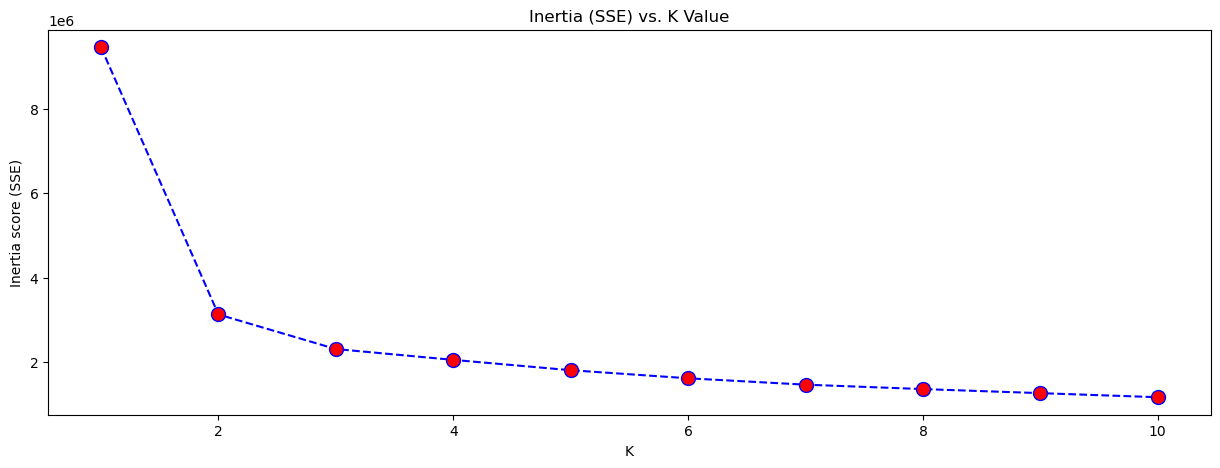

In [30]:
from tqdm import tqdm
from sklearn.cluster import KMeans

socio_economic_cols = ['home_ownership', 'grade', 'emp_length', 'last_fico_range_high', 'last_fico_range_low']

elbow_joint(socio_economic_cols, x_train)
df_cluster_summary, x_train, x_test = clustering(3, 'socio_economic', socio_economic_cols, x_train, x_test)
df_cluster_summary

Loan Attributes

  0%|                                                    | 0/10 [00:00<?, ?it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1


 10%|████▍                                       | 1/10 [00:00<00:02,  3.82it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


 20%|████████▊                                   | 2/10 [00:00<00:04,  1.91it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


 30%|█████████████▏                              | 3/10 [00:02<00:05,  1.31it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


 40%|█████████████████▌                          | 4/10 [00:03<00:06,  1.05s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5


 50%|██████████████████████                      | 5/10 [00:04<00:05,  1.19s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6


 60%|██████████████████████████▍                 | 6/10 [00:06<00:05,  1.30s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7


 70%|██████████████████████████████▊             | 7/10 [00:08<00:04,  1.39s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8


 80%|███████████████████████████████████▏        | 8/10 [00:10<00:03,  1.64s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9


 90%|███████████████████████████████████████▌    | 9/10 [00:12<00:01,  1.91s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/it]
/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_ids_loan_attributes,column,metric,0,1,2
1,loan_amnt,mean,-0.155072,-0.147626,0.662828
17,int_rate,mean,0.190450,-0.932410,1.503354
529,term,mean,0.306320,0.102163,0.696131
537,grade,mean,3.305991,1.665305,5.023889


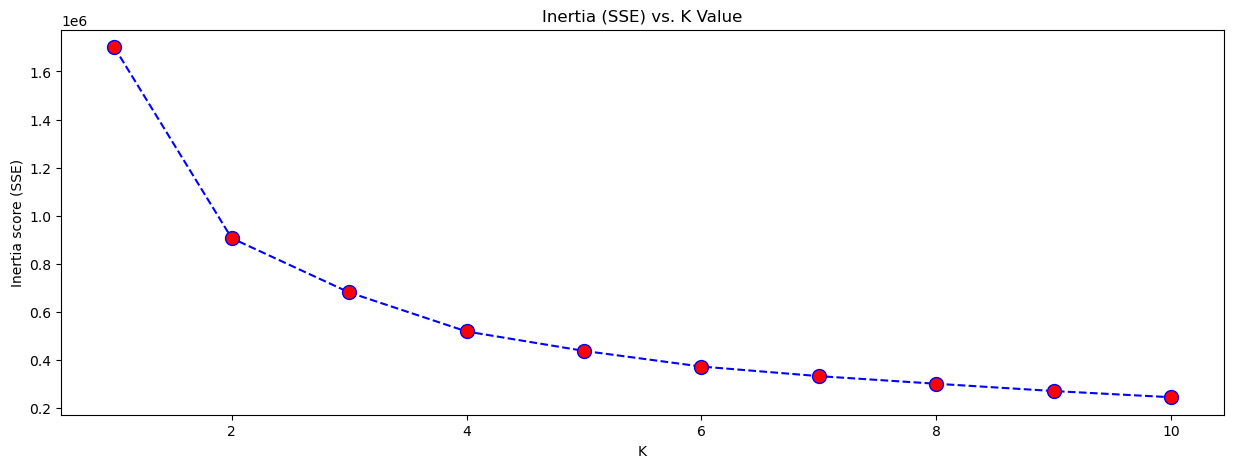

In [31]:
loan_cols = ['loan_amnt', 'term', 'grade', 'int_rate']

elbow_joint(loan_cols, x_train)
df_cluster_summary, x_train, x_test = clustering(3, 'loan_attributes', loan_cols, x_train, x_test)
df_cluster_summary

# Dimensionality Reduction: PCA 

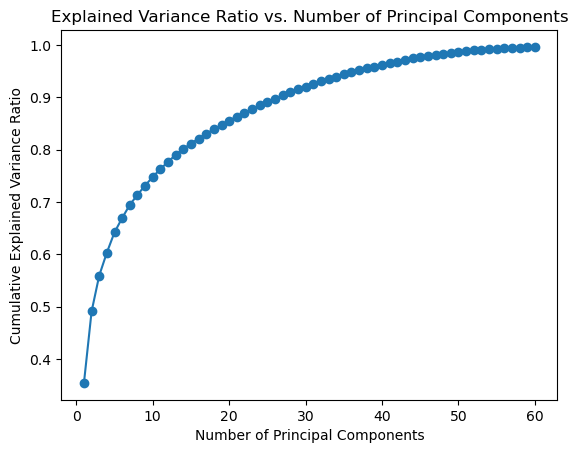

In [32]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 60)
X_pca = pca.fit_transform(x_train)

explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.show()

In [33]:
target_variance = 0.95
num_components_for_target_variance = np.argmax(cumulative_var_ratio >= target_variance) + 1
print(f"Number of components needed for {target_variance*100}% explained variance: {num_components_for_target_variance}")

Number of components needed for 95.0% explained variance: 37


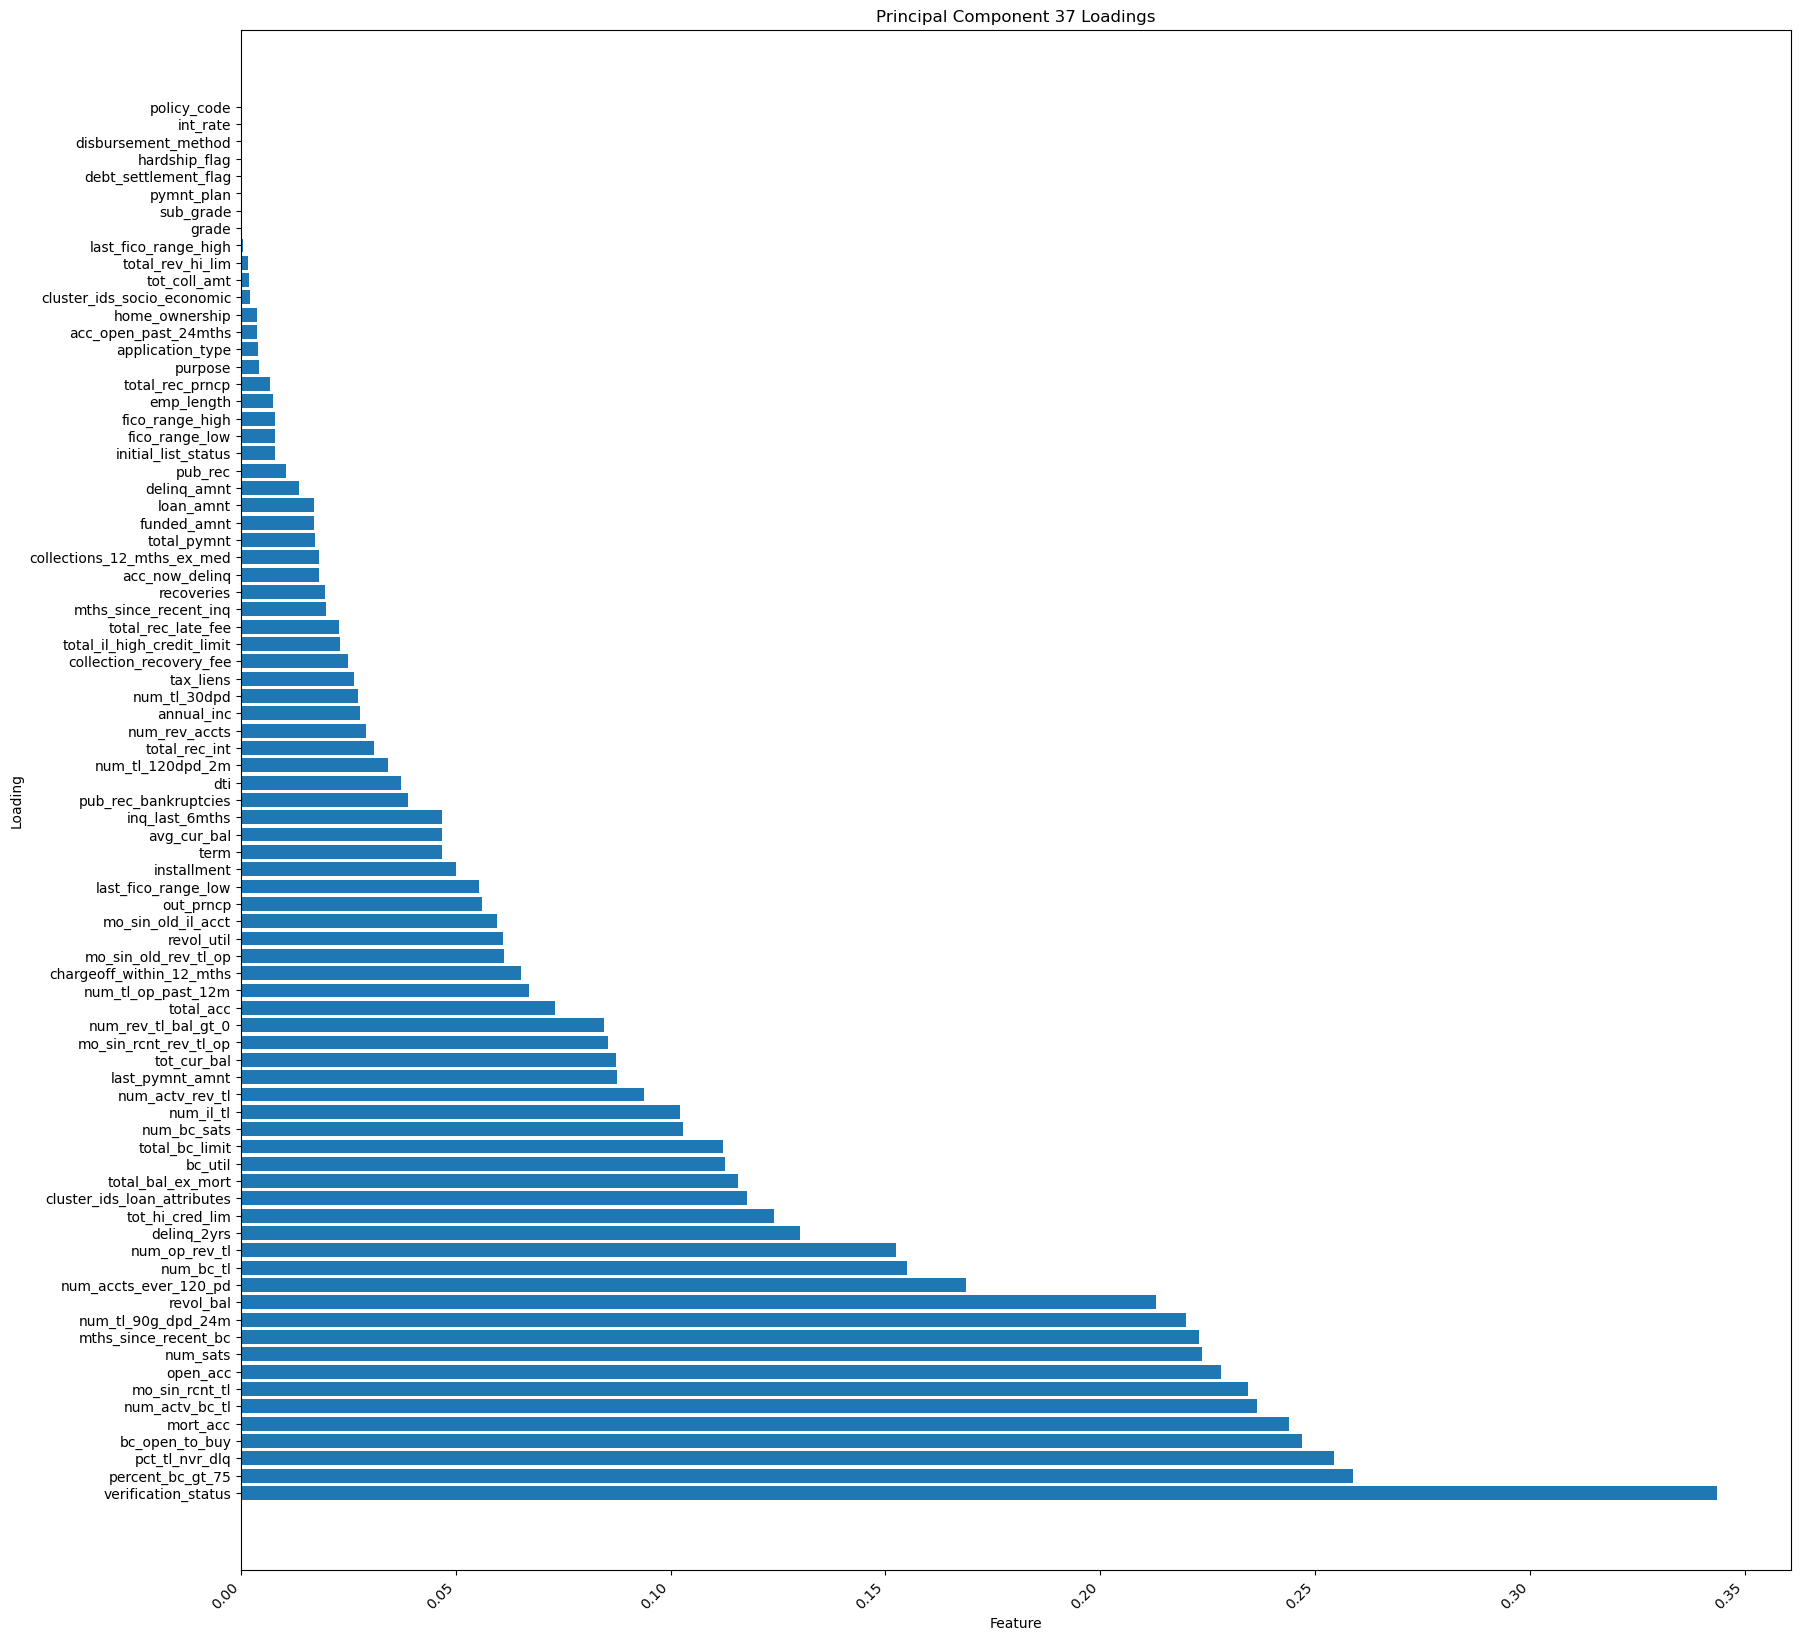

In [34]:
feature_names = x_train.columns[:]
loading_target_component = pca.components_[num_components_for_target_variance - 1, :]
sorted_indices = np.argsort(np.abs(loading_target_component))[::-1]

plt.figure(figsize=(20, 20))
plt.barh([feature_names[i] for i in sorted_indices], np.abs(loading_target_component[sorted_indices]))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Loading')
plt.title(f'Principal Component {num_components_for_target_variance} Loadings')
plt.show()

In [35]:
important_features = [feature_names[i] for i in sorted_indices[:num_components_for_target_variance]]
x_train = x_train[important_features]
x_train.shape

(425056, 37)

In [36]:
cols = x_train.columns
x_test = x_test[cols]

# K Means Clustering - Creating Clusters of Customers

  0%|                                                    | 0/10 [00:00<?, ?it/s]

1


/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|████▍                                       | 1/10 [00:00<00:07,  1.17it/s]

2


/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 20%|████████▊                                   | 2/10 [00:03<00:14,  1.77s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


 30%|█████████████▏                              | 3/10 [00:07<00:20,  2.90s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


 40%|█████████████████▌                          | 4/10 [00:15<00:28,  4.76s/it]

5


/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 50%|██████████████████████                      | 5/10 [00:26<00:35,  7.13s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6


 60%|██████████████████████████▍                 | 6/10 [00:41<00:39,  9.86s/it]

7


/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 70%|██████████████████████████████▊             | 7/10 [00:56<00:34, 11.63s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8


 80%|███████████████████████████████████▏        | 8/10 [01:10<00:24, 12.36s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9


 90%|███████████████████████████████████████▌    | 9/10 [01:28<00:13, 13.99s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


100%|███████████████████████████████████████████| 10/10 [01:49<00:00, 10.91s/it]


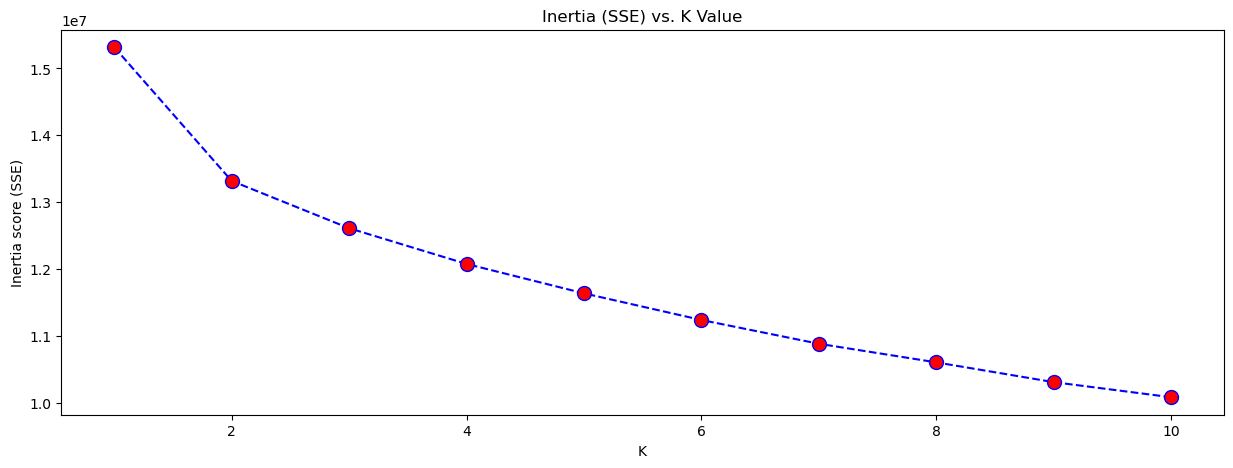

In [37]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score


elbow_joint(x_train.columns.tolist(), x_train)



# Evaluation - ROC

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

def logistic_regression(x_train, y_train, x_test, y_test):
    model = LogisticRegression(max_iter=1000, solver='liblinear') 
    model.fit(x_train, y_train)
    y_pred_prob = model.predict_proba(x_test[important_features])[:, 1]
    return y_pred_prob

    
def evaluation_roc_cm(y_test, y_pred): 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print("ROC Score : ", str(roc_auc))
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Perfect fit')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    print()
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


    print("Confusion Matrix")
    print(cm)
    print()
    print("Accuracy of the model is: ", accuracy_score(y_pred,y_test))

# Methods

# Method 1: Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

print('Random Forest Classification')
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

classifier_rf.fit(x_train, y_train)
print(classifier_rf.oob_score_)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [2,5],
    'min_samples_leaf': [5,10],
    'n_estimators': [5,10]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")


grid_search.fit(x_train, y_train)

Random Forest Classification
0.9333264322818641
Fitting 4 folds for each of 8 candidates, totalling 32 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5], 'min_samples_leaf': [5, 10],
                         'n_estimators': [5, 10]},
             scoring='accuracy', verbose=1)

ROC Score :  0.9328238228793493


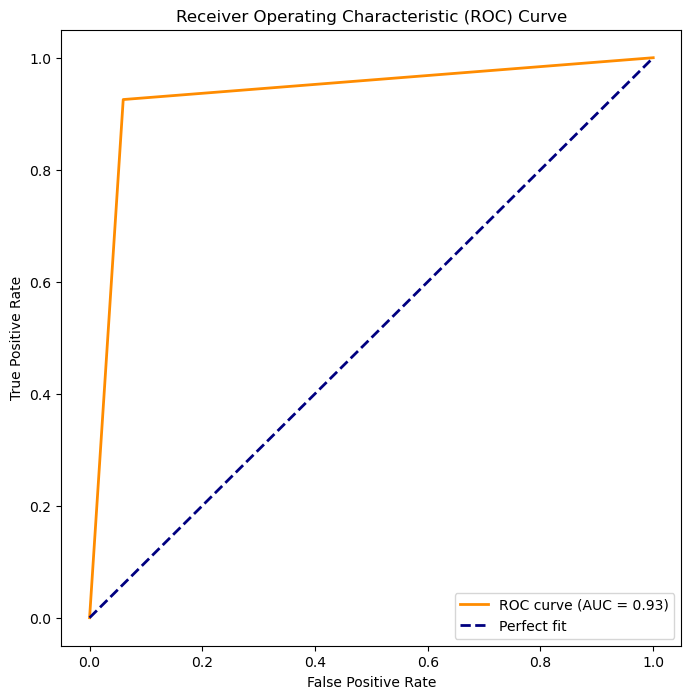

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     91174
           1       0.94      0.93      0.93     90994

    accuracy                           0.93    182168
   macro avg       0.93      0.93      0.93    182168
weighted avg       0.93      0.93      0.93    182168




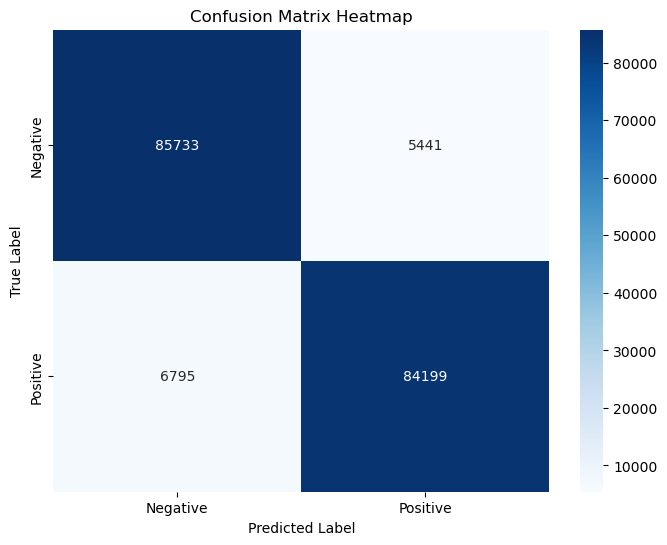

Confusion Matrix
[[85733  5441]
 [ 6795 84199]]

Accuracy of the model is:  0.9328312327082693


In [40]:
rf_best = grid_search.best_estimator_
y_pred = rf_best.predict(x_test)
evaluation_roc_cm(y_test, y_pred)

<Figure size 1000x600 with 0 Axes>

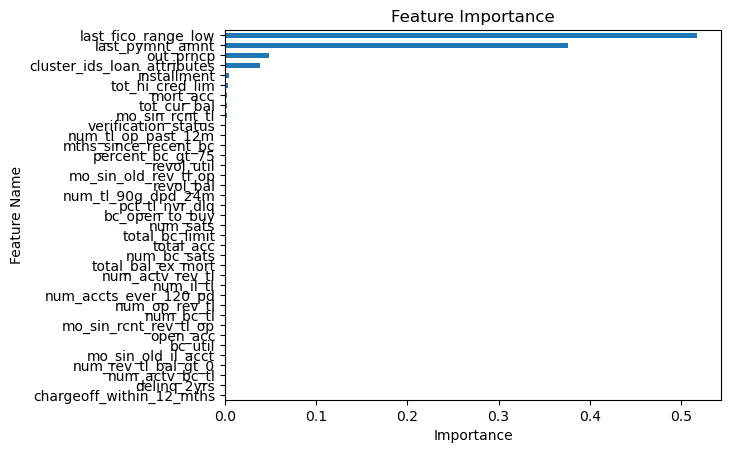

['last_fico_range_low', 'last_pymnt_amnt']


In [41]:
imp_df = feature_importance(grid_search, x_train)
print_impt_features(x_train, imp_df)

In [42]:
cols = ['last_pymnt_amnt', 'last_fico_range_low']
# elbow_joint(cols, x_train)
df_cluster_summary, x_train, x_test = clustering(4, 'rf', cols, x_train, x_test)
df_cluster_summary

/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_ids_rf,column,metric,0,1,2,3
193,last_pymnt_amnt,mean,-0.493964,2.343628,-0.486278,-0.030482
281,last_fico_range_low,mean,-0.196405,0.591603,-3.625617,0.641733


# XGBoost Classifier 

In [43]:
!pip install xgboost 
import xgboost as xgb

In [44]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0],
    'n_estimators': [10, 50, 100]
}

grid_search = GridSearchCV(model, param_grid, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(x_train.drop(columns=['cluster_ids_rf']), y_train.drop(columns=['cluster_ids_rf']))

Fitting 4 folds for each of 48 candidates, totalling 192 fits


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [10, 50, 100],
                         'subsample': [0.5, 1.0]},
             scoring='accuracy', verbose=1)

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
ROC Score :  0.9455322918075785


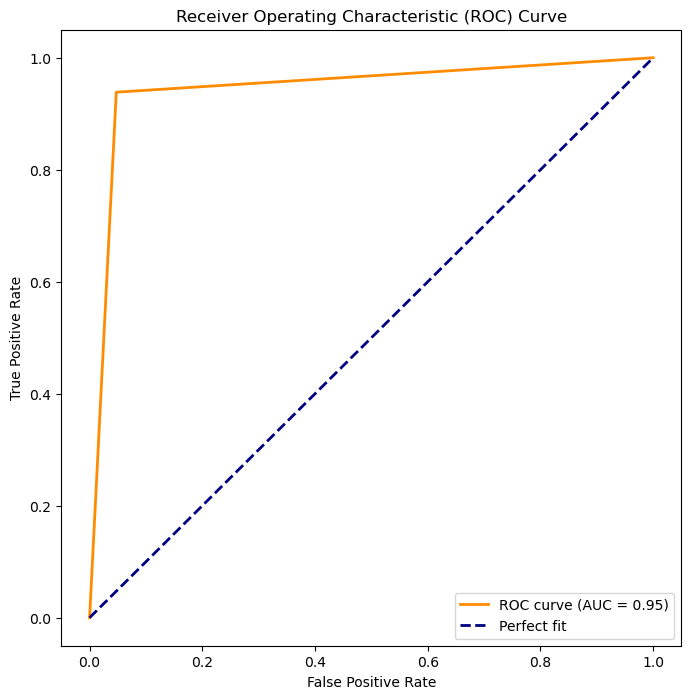

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     91174
           1       0.95      0.94      0.95     90994

    accuracy                           0.95    182168
   macro avg       0.95      0.95      0.95    182168
weighted avg       0.95      0.95      0.95    182168




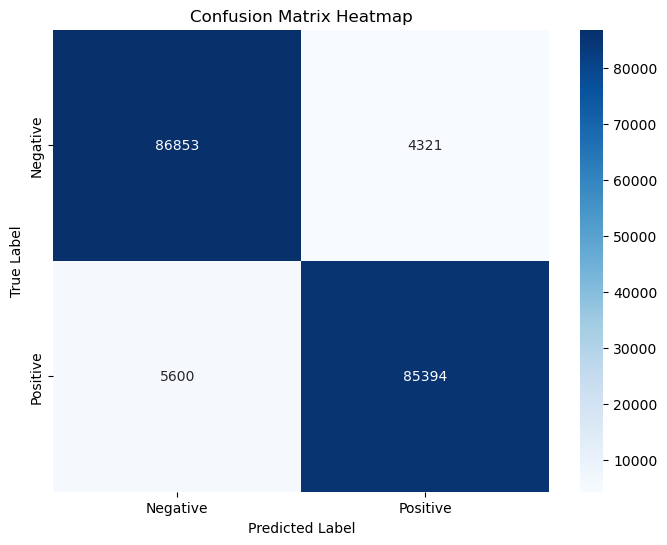

Confusion Matrix
[[86853  4321]
 [ 5600 85394]]

Accuracy of the model is:  0.9455392824206227


In [45]:
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test.drop(columns=['cluster_ids_rf']))
evaluation_roc_cm(y_test, y_pred)

<Figure size 1000x600 with 0 Axes>

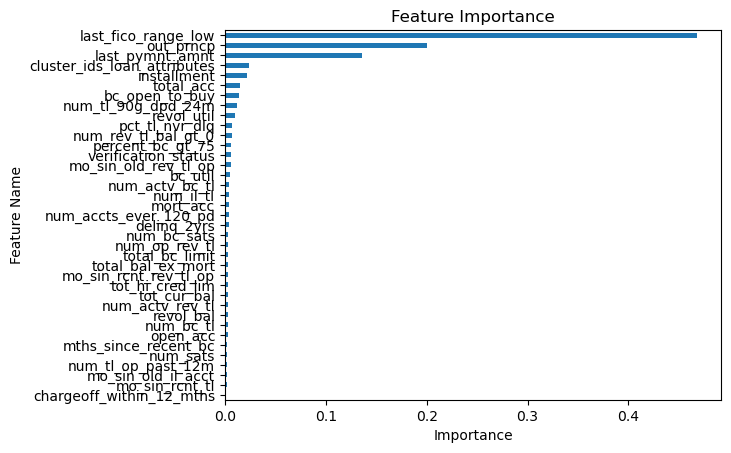

['last_fico_range_low', 'out_prncp', 'last_pymnt_amnt']


In [46]:
imp_df = feature_importance(grid_search, x_train.drop(columns=['cluster_ids_rf']))
print_impt_features(x_train.drop(columns=['cluster_ids_rf']), imp_df)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

1


/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|████▍                                       | 1/10 [00:00<00:02,  3.88it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


 20%|████████▊                                   | 2/10 [00:00<00:04,  1.92it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


 30%|█████████████▏                              | 3/10 [00:01<00:04,  1.47it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


 40%|█████████████████▌                          | 4/10 [00:02<00:05,  1.18it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5


 50%|██████████████████████                      | 5/10 [00:04<00:05,  1.10s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6


 60%|██████████████████████████▍                 | 6/10 [00:06<00:05,  1.31s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7


 70%|██████████████████████████████▊             | 7/10 [00:07<00:04,  1.45s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8


 80%|███████████████████████████████████▏        | 8/10 [00:10<00:03,  1.80s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9


 90%|███████████████████████████████████████▌    | 9/10 [00:12<00:01,  1.99s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.56s/it]
/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_ids_xg,column,metric,0,1,2,3
193,last_pymnt_amnt,mean,1.992784,-0.356163,-0.473166,-0.485998
273,out_prncp,mean,-0.193270,-0.145872,5.166192,-0.161421
281,last_fico_range_low,mean,0.605831,0.133195,0.095967,-3.625617


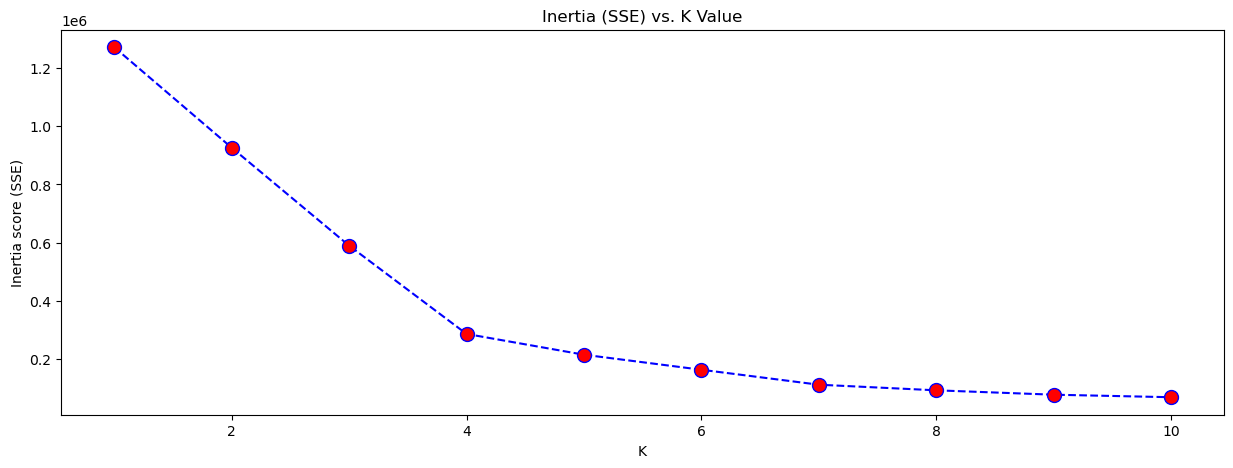

In [47]:
cols = ['last_pymnt_amnt', 'last_fico_range_low', 'out_prncp']
elbow_joint(cols, x_train)
df_cluster_summary, x_train, x_test = clustering(4, 'xg', cols, x_train, x_test)
df_cluster_summary

# Logistic Regression 

In [48]:
lr = LogisticRegression()
params = {"solver": ["newton-cg", "lbfgs", "liblinear"],  
                "class_weight": ["balanced", ""], 
                "max_iter" : [500, 1000, 2000]
                 }

print("Logistic Regression Fine Tuning")
grid_search = GridSearchCV(estimator=lr,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x_train.drop(columns=['cluster_ids_rf', 'cluster_ids_xg']), y_train.drop(columns=['cluster_ids_rf', 'cluster_ids_xg']))

lr_best = grid_search.best_estimator_
lr_best

Logistic Regression Fine Tuning
Fitting 4 folds for each of 18 candidates, totalling 72 fits


/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File

LogisticRegression(class_weight='balanced', max_iter=500, solver='newton-cg')

Best parameters found:  LogisticRegression(class_weight='balanced', max_iter=500, solver='newton-cg')
ROC Score :  0.9334210716276483


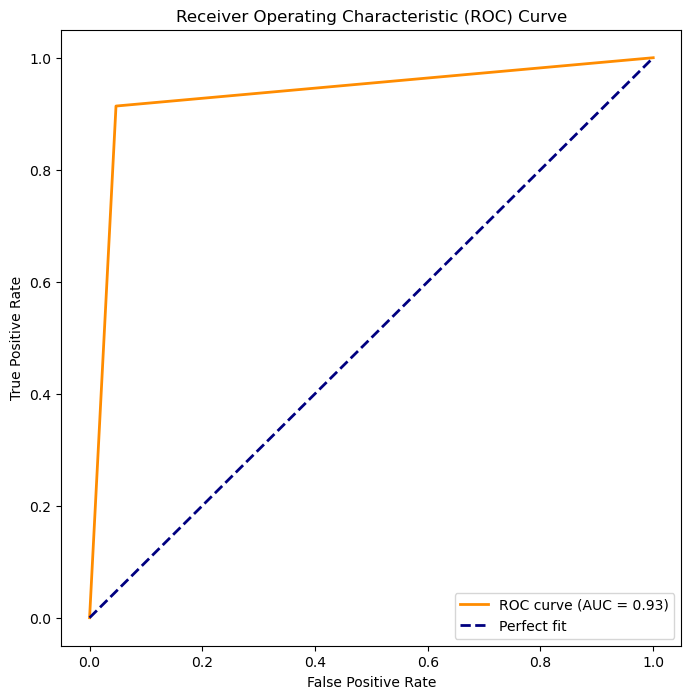

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     91174
           1       0.95      0.91      0.93     90994

    accuracy                           0.93    182168
   macro avg       0.93      0.93      0.93    182168
weighted avg       0.93      0.93      0.93    182168




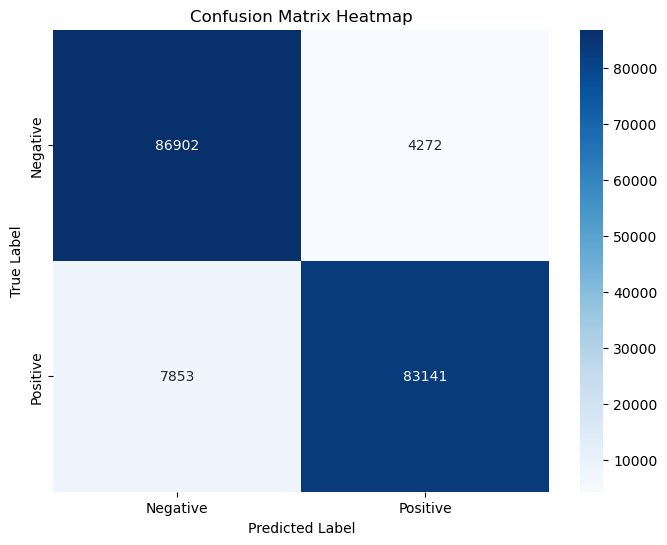

Confusion Matrix
[[86902  4272]
 [ 7853 83141]]

Accuracy of the model is:  0.9334405603618637


In [49]:
print("Best parameters found: ", lr_best)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test.drop(columns=['cluster_ids_rf', 'cluster_ids_xg']))
evaluation_roc_cm(y_test, y_pred)

<Axes: ylabel='Feature'>

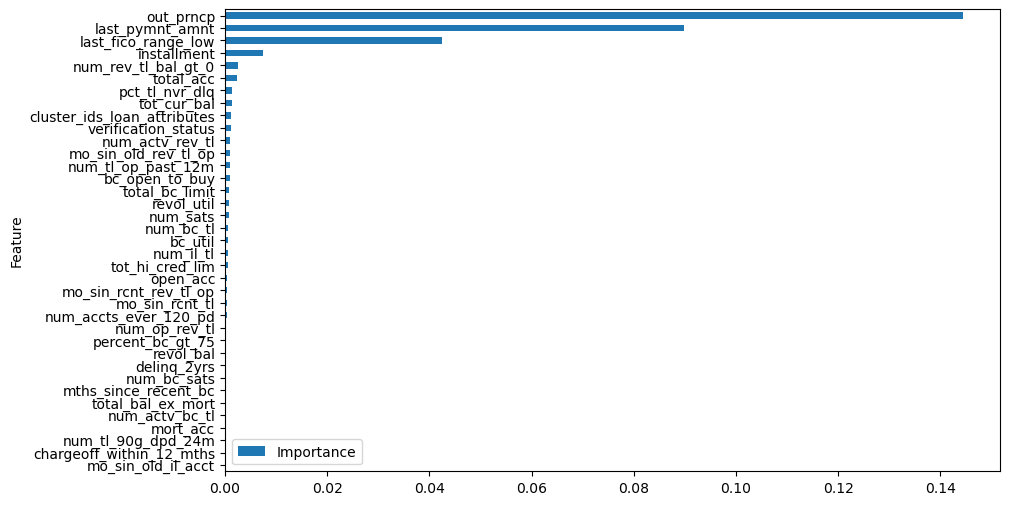

In [50]:
best_model = grid_search.best_estimator_
coefficients = best_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': x_train.drop(columns=['cluster_ids_rf', 'cluster_ids_xg']).columns, 'Importance': np.abs(coefficients)/100})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


In [51]:
feature_importance.rename(columns = {'Importance': 'Imp', 'Feature':'Varname'}, inplace=True)
print_impt_features(x_train.drop(columns=['cluster_ids_rf', 'cluster_ids_xg']), feature_importance)


['out_prncp']


  0%|                                                    | 0/10 [00:00<?, ?it/s]

1


/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|████▍                                       | 1/10 [00:00<00:01,  5.00it/s]

2


/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 20%|████████▊                                   | 2/10 [00:00<00:03,  2.13it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


 30%|█████████████▏                              | 3/10 [00:01<00:04,  1.42it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


 40%|█████████████████▌                          | 4/10 [00:03<00:05,  1.08it/s]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5


 50%|██████████████████████                      | 5/10 [00:04<00:06,  1.23s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6


 60%|██████████████████████████▍                 | 6/10 [00:06<00:06,  1.52s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7


 70%|██████████████████████████████▊             | 7/10 [00:09<00:05,  1.77s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8


 80%|███████████████████████████████████▏        | 8/10 [00:11<00:03,  1.99s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9


 90%|███████████████████████████████████████▌    | 9/10 [00:14<00:02,  2.30s/it]/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]
/Users/patsy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_ids_lr,column,metric,0,1,2,3
273,out_prncp,mean,-0.186017,4.74827,2.112094,8.316141


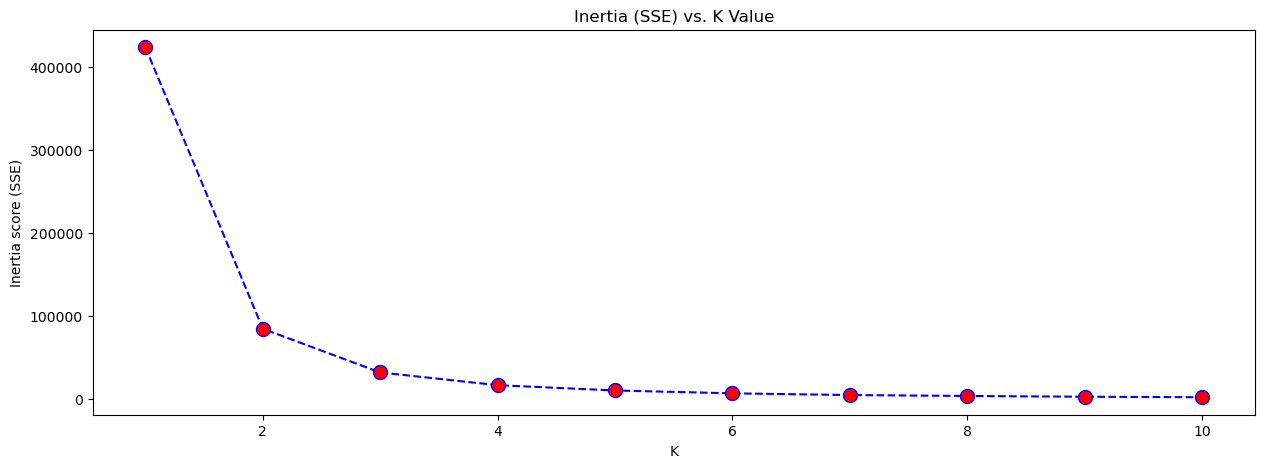

In [52]:
cols = ['out_prncp']
elbow_joint(cols, x_train)
df_cluster_summary, x_train, x_test = clustering(4, 'lr', cols, x_train, x_test)
df_cluster_summary

# Combined Classifier: XGBoost with the Identified Customer Segments 

Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
ROC Score :  0.9456143785294593


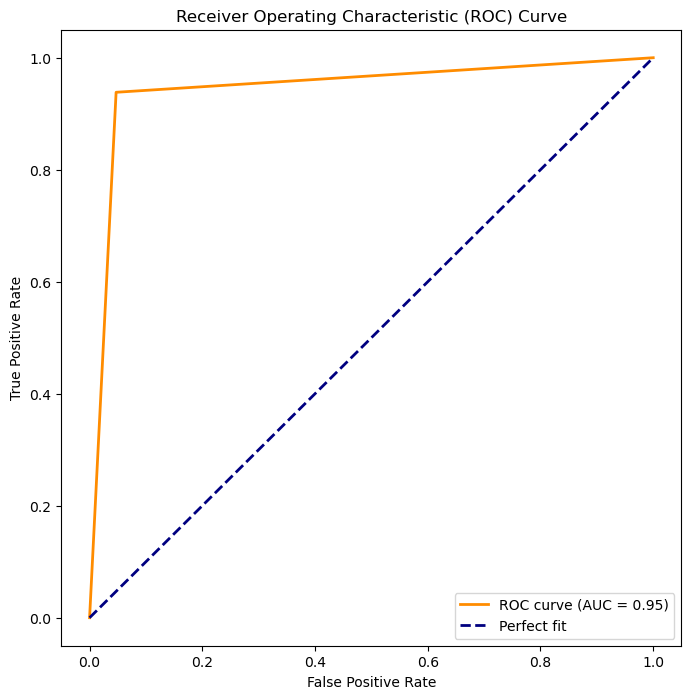

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     91174
           1       0.95      0.94      0.95     90994

    accuracy                           0.95    182168
   macro avg       0.95      0.95      0.95    182168
weighted avg       0.95      0.95      0.95    182168




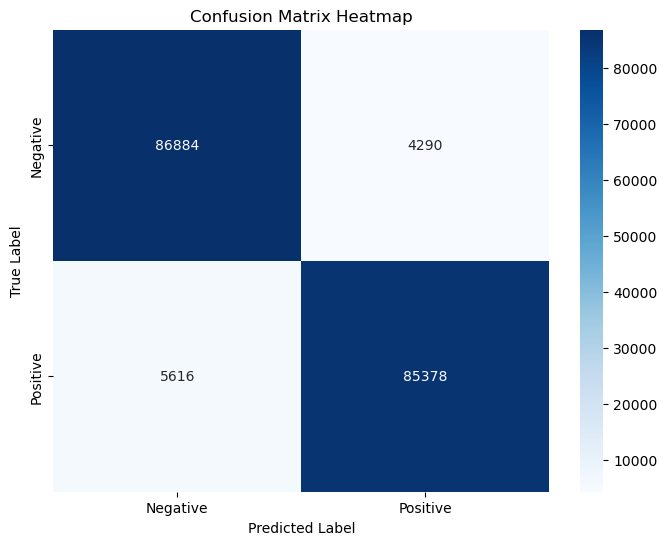

Confusion Matrix
[[86884  4290]
 [ 5616 85378]]

Accuracy of the model is:  0.9456216239954328


In [62]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0],
    'n_estimators': [10, 50, 100]
}

grid_search = GridSearchCV(model, param_grid, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(x_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
evaluation_roc_cm(y_test, y_pred)

In [65]:
est = grid_search.best_estimator_
imp_df = pd.DataFrame({
        "Varname": x_train.columns,
        "Imp": est.feature_importances_
    })
imp_df = imp_df.sort_values(by = 'Imp', ascending = True)
imp_df.loc[imp_df['Imp']>0.1]

,Varname,Imp
24,last_pymnt_amnt,0.106916
34,out_prncp,0.155555
37,cluster_ids_rf,0.158686
35,last_fico_range_low,0.413551


In [66]:
print_impt_features(x_train, imp_df)


['last_fico_range_low', 'cluster_ids_rf', 'out_prncp', 'last_pymnt_amnt']


# Combined Classifier: XGBoost with just 4 features

In [56]:
cols = ['last_fico_range_low', 'cluster_ids_rf', 'out_prncp', 'last_pymnt_amnt']

Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
ROC Score :  0.9341764772727565


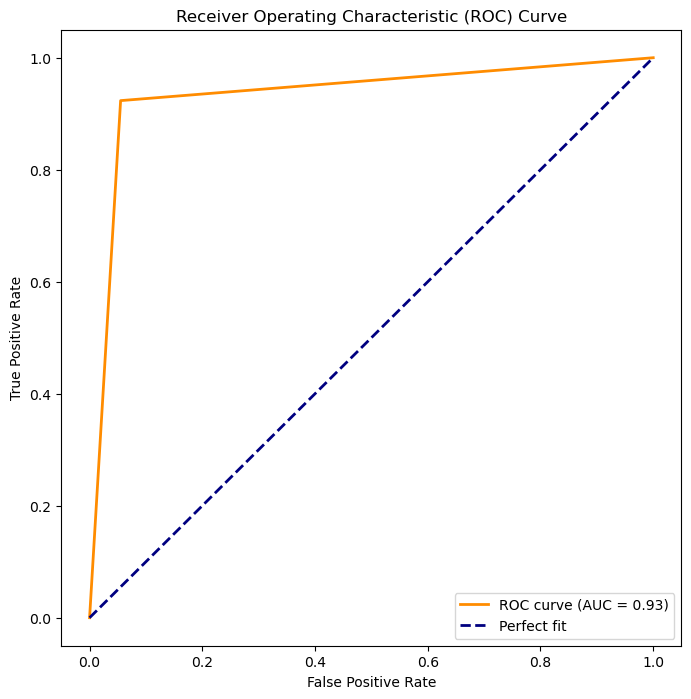

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     91174
           1       0.94      0.92      0.93     90994

    accuracy                           0.93    182168
   macro avg       0.93      0.93      0.93    182168
weighted avg       0.93      0.93      0.93    182168




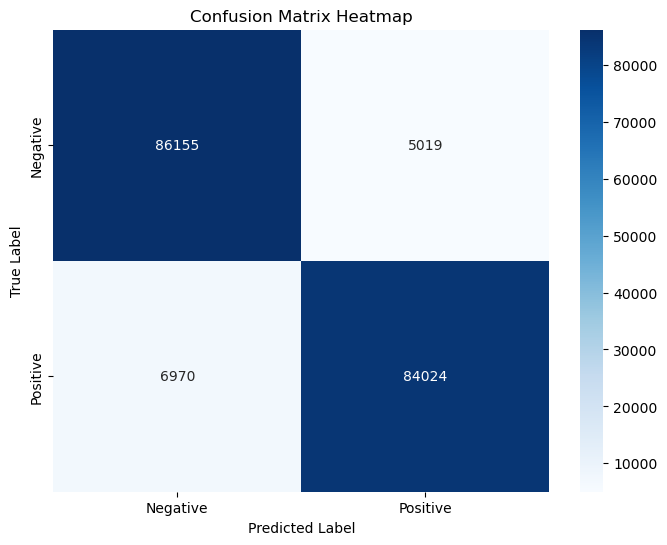

Confusion Matrix
[[86155  5019]
 [ 6970 84024]]

Accuracy of the model is:  0.934187123973475


In [57]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0],
    'n_estimators': [10, 50, 100]
}

grid_search = GridSearchCV(model, param_grid, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(x_train[cols], y_train)
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test[cols])
evaluation_roc_cm(y_test, y_pred)